In [164]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv
import itertools as it
import networkx as nx
import random

1)

In [3]:
G = nx.Graph()

with open('./data.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    for row in reader:
        autores = [autor.strip() for autor in row[3].split('&')]
        coautorias = it.combinations(autores, 2)
        G.add_edges_from(coautorias)


In [4]:
print("nodos: {0}".format(G.number_of_nodes()))
print("aristas: {0}".format(G.number_of_edges()))

nodos: 3698
aristas: 7880


In [95]:
nx.draw(G)

TypeError: 'module' object is not callable

2)

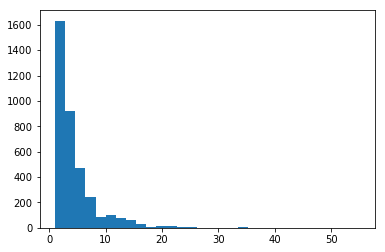

In [6]:
grados = list(nx.degree(G).values())
count, bins, patches = plt.hist(grados, bins=30)
plt.show()

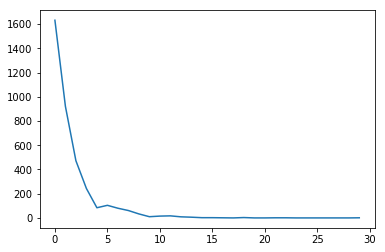

In [7]:
plt.plot(count)

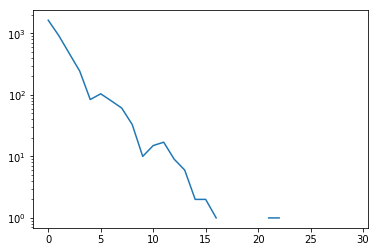

In [8]:
plt.semilogy(count)

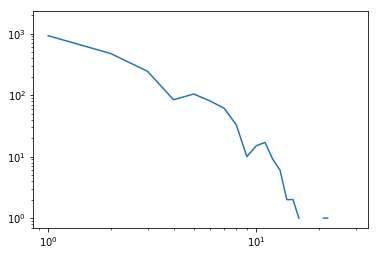

In [9]:
plt.loglog(count)

3)

In [10]:
componentes_conexas = [x for x in nx.connected_components(G)]

tupla_componente_gigante = max([(x, len(x)) for x in componentes_conexas], key=lambda x:x[1])

print("cantidad de componentes conexas: ", len(componentes_conexas))
print("componente conexa gigante: ", tupla_componente_gigante[1])

cantidad de componentes conexas:  236
componente conexa gigante:  3018


4)

In [133]:
all_distances = nx.all_pairs_shortest_path_length(componente_gigante)

In [177]:
def invert_map(map):
    inv_map = {}
    for k, v in map.items():
        inv_map.setdefault(v, [])
        inv_map[v].append(k)
    return inv_map

def authors_by_distance(componente_gigante):
    nodo_raiz_idx = random.randint(0, len(componente_gigante) - 1)
    nodo_raiz = componente_gigante.nodes()[nodo_raiz_idx]

    paths = invert_map(all_distances[nodo_raiz])
    diferencial = {}
    
    previous_quantity = 0
    for distance in sorted(paths.keys()):
        diferencial[distance] = len(paths[distance]) 
        
    return diferencial

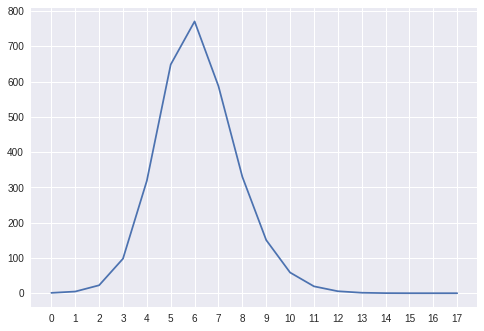

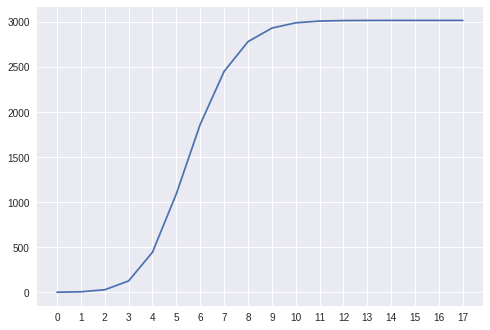

In [193]:
componente_gigante = G.subgraph(tupla_componente_gigante[0])

iterations = 2000
longest_path = max([max(node_distances.values()) for node_distances in all_distances.values()]) + 1
results = np.zeros((iterations, longest_path), dtype=int)

for iteration in range(iterations):
    diferencial = authors_by_distance(componente_gigante)
    
    for distance, quantity in diferencial.items():
        results[iteration, distance] = quantity

diferencial_means = results.mean(axis=0)
incremental_means = []

previous_quantity = 0
for quantity in diferencial_means:
    incremental_means.append(quantity + previous_quantity)
    previous_quantity = quantity + previous_quantity

def plot(y):
    sns.plt.figure()
    sns.plt.xticks(range(longest_path+1))
    sns.plt.plot(range(longest_path),y)


plot(diferencial_means)
plot(incremental_means)